In [ ]:
import pandas as pd
df = pd.read_csv('/kaggle/input/pos-arman/df_pos.csv',encoding='utf-8')
df.head()

,texts,label,pos
0,अमेरिकी और रूसी पुलिस के संयुक्त अभियान के फलस...,0,"['ADJ', 'CCONJ', 'ADJ', 'NOUN', 'ADP', 'ADJ', ..."
1,आज यहां रांची एक्सप्रेस के साथ बातचीत में वित्...,0,"['NOUN', 'PRON', 'PROPN', 'PROPN', 'ADP', 'ADP..."
2,हमे इन्तजार है ।,1,"['PRON', 'NOUN', 'AUX', 'PUNCT']"
3,जिस के नतीजे मे ये हुक्म सादिर किया गया है ।,1,"['PRON', 'ADP', 'NOUN', 'ADP', 'DET', 'NOUN', ..."
4,जयपुर,0,['PROPN']


In [ ]:
df = df[df['texts'].apply(lambda x: isinstance(x, str))]

1. **TTR (Type-Token Ratio)**
2. **POS Ratios**
   - Adverb/Adjective
   - Adverb/Noun
   - Adverb/Pronoun
   - Adjective/Verb
   - Adjective/Pronoun
   - Noun/Verb
   - Noun/Pronoun
   - Verb/Pronoun
3. **Content/Function Word Ratio**
4. **ISC Score (Syntactic Complexity)**
5. **ADD Score (Average Dependency Distance)**
6. **Sentence Length Statistics**
   - Average Sentence Length
   - Standard Deviation of Sentence Length
  

* ISC Score (Syntactic Complexity): Measures the complexity of sentences based on conjunctions, verbs, and noun phrases.
* ADD Score (Average Dependency Distance): Average distance between words in terms of their syntactic dependency relations.
* Average Sentence Length (avg_sen_len): Mean length of sentences in terms of number of words.
* Standard Deviation of Sentence Length (std_sen_len): Standard deviation of sentence lengths.

In [ ]:
import pandas as pd
import numpy as np
from collections import Counter
from indicnlp.tokenize import indic_tokenize
import re

class LexicalDiversity:
    def __init__(self, text, pos):
        self.text = text
        self.tokens = indic_tokenize.trivial_tokenize(self.text)
        self.pos = pos
        self.sentences = self.split_sentences(self.text)

    def lexical_diversity(self):
        ttr = self.ttr(self.tokens)
        pos_ratios = self.calculate_pos_ratios()
        content_function_ratio = self.calculate_content_function_ratio()
        isc_score = self.calculate_isc_score()
        add_score = self.calculate_add_score()
        avg_sen_len, std_sen_len = self.calculate_sentence_length_stats()

        return {
            "TTR": ttr,
            **pos_ratios,
            "Content/Function": content_function_ratio,
            "ISC Score": isc_score,
            "ADD Score": add_score,
            "Average Sentence Length": avg_sen_len,
            "Std Dev Sentence Length": std_sen_len
        }

    def ttr(self, tokens):
        return len(set(tokens)) / len(tokens) if tokens else 0

    def calculate_pos_ratios(self):
        pos_counts = Counter(self.pos)

        ratios = {
            "Adverb/Adjective": self.safe_divide(pos_counts['ADV'], pos_counts['ADJ']),
            "Adverb/Noun": self.safe_divide(pos_counts['ADV'], pos_counts['NOUN']),
            "Adverb/Pronoun": self.safe_divide(pos_counts['ADV'], pos_counts['PRON']),
            "Adjective/Verb": self.safe_divide(pos_counts['ADJ'], pos_counts['VERB']),
            "Adjective/Pronoun": self.safe_divide(pos_counts['ADJ'], pos_counts['PRON']),
            "Noun/Verb": self.safe_divide(pos_counts['NOUN'], pos_counts['VERB']),
            "Noun/Pronoun": self.safe_divide(pos_counts['NOUN'], pos_counts['PRON']),
            "Verb/Pronoun": self.safe_divide(pos_counts['VERB'], pos_counts['PRON']),
        }

        return ratios

    def calculate_content_function_ratio(self):
        content_words = sum(self.pos.count(tag) for tag in ['NOUN', 'VERB', 'ADJ', 'ADV'])
        function_words = sum(self.pos.count(tag) for tag in ['PRON', 'ADP', 'DET', 'CONJ', 'SCONJ', 'PART'])
        return self.safe_divide(content_words, function_words)

    def calculate_isc_score(self):
        # Approximation: count conjunctions, verbs, and nouns
        conjunctions = self.pos.count('CCONJ') + self.pos.count('SCONJ')
        verbs = self.pos.count('VERB')
        nouns = self.pos.count('NOUN')
        return self.safe_divide(conjunctions + verbs + nouns, len(self.tokens))

    def calculate_add_score(self):
        # Approximation: average distance between content words
        content_word_indices = [i for i, pos in enumerate(self.pos) if pos in ['NOUN', 'VERB', 'ADJ', 'ADV']]
        if len(content_word_indices) < 2:
            return 0
        distances = [j - i for i, j in zip(content_word_indices[:-1], content_word_indices[1:])]
        return sum(distances) / len(distances)

    def split_sentences(self, text):
        # Simple sentence splitting based on punctuation
        return re.split(r'[।!?]+', text)

    def calculate_sentence_length_stats(self):
        sentence_lengths = [len(indic_tokenize.trivial_tokenize(sent)) for sent in self.sentences if sent.strip()]
        if not sentence_lengths:
            return 0, 0
        return np.mean(sentence_lengths), np.std(sentence_lengths)

    def safe_divide(self, numerator, denominator):
        return numerator / denominator if denominator != 0 else 0

def calculate_features(row):
    ld_obj = LexicalDiversity(row['texts'], row['pos'])
    return ld_obj.lexical_diversity()

# Convert the 'pos' column from string to list
df['pos'] = df['pos'].apply(eval)

# Apply the function to each row in the DataFrame
features_df = df.apply(calculate_features, axis=1).apply(pd.Series)

# Concatenate the new features with the original DataFrame
df = pd.concat([df, features_df], axis=1)

# Save the updated DataFrame
df.to_csv('lexicalandpos_features.csv', index=False)

In [ ]:
df.head()

,texts,label,pos,TTR,Adverb/Adjective,Adverb/Noun,Adverb/Pronoun,Adjective/Verb,Adjective/Pronoun,Noun/Verb,Noun/Pronoun,Verb/Pronoun,Content/Function,ISC Score,ADD Score,Average Sentence Length,Std Dev Sentence Length
0,अमेरिकी और रूसी पुलिस के संयुक्त अभियान के फलस...,0,"[ADJ, CCONJ, ADJ, NOUN, ADP, ADJ, NOUN, ADP, A...",0.857143,0.0,0.0,0.0,3.5,0.0,3.5,0.0,0.0,3.2,0.392857,1.600000,27.0,0.0
1,आज यहां रांची एक्सप्रेस के साथ बातचीत में वित्...,0,"[NOUN, PRON, PROPN, PROPN, ADP, ADP, NOUN, ADP...",1.000000,0.0,0.0,0.0,0.0,0.0,2.0,2.0,1.0,0.5,0.307692,5.000000,13.0,0.0
2,हमे इन्तजार है ।,1,"[PRON, NOUN, AUX, PUNCT]",1.000000,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.250000,0.000000,3.0,0.0
3,जिस के नतीजे मे ये हुक्म सादिर किया गया है ।,1,"[PRON, ADP, NOUN, ADP, DET, NOUN, NOUN, VERB, ...",1.000000,0.0,0.0,0.0,0.0,0.0,3.0,3.0,1.0,1.0,0.363636,1.666667,10.0,0.0
4,जयपुर,0,[PROPN],1.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,1.0,0.0


In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score

In [ ]:
# Separate features and target
X = df.drop('label', axis=1)
X = X.drop('texts', axis=1)
X = X.drop('pos', axis=1)
y = df['label']

In [ ]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

In [ ]:
logistic_regression = LogisticRegression(random_state=42)
logistic_regression.fit(X_train, y_train)
y_pred_logistic = logistic_regression.predict(X_test)
accuracy_logistic = accuracy_score(y_test, y_pred_logistic)
print("\nLogistic Regression Accuracy:", accuracy_logistic)
print("\nClassification Report:")
print(classification_report(y_test, y_pred_logistic))


Logistic Regression Accuracy: 0.7088394934091496

Classification Report:
              precision    recall  f1-score   support

           0       0.70      0.71      0.71      3826
           1       0.71      0.71      0.71      3912

    accuracy                           0.71      7738
   macro avg       0.71      0.71      0.71      7738
weighted avg       0.71      0.71      0.71      7738



Feature Importance:
 TTR                        0.803661
Noun/Verb                  0.555424
Noun/Pronoun               0.349520
Content/Function           0.269345
Adjective/Verb             0.265812
Verb/Pronoun               0.222592
Adjective/Pronoun          0.204922
Adverb/Noun                0.161462
Average Sentence Length    0.159971
ISC Score                  0.152915
ADD Score                  0.144539
Adverb/Pronoun             0.086378
Std Dev Sentence Length    0.053854
Adverb/Adjective           0.021682
dtype: float64


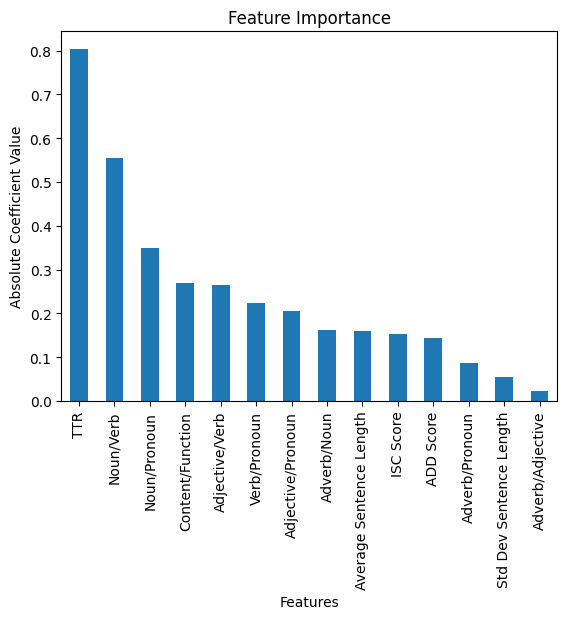

In [ ]:
coefficients = logistic_regression.coef_[0]
feature_importance = pd.Series(coefficients, index=X.columns)

# Get the absolute values of the coefficients to determine importance
feature_importance = np.abs(feature_importance)
feature_importance = feature_importance.sort_values(ascending=False)

print("Feature Importance:\n", feature_importance)

# Optionally, visualize the feature importance
import matplotlib.pyplot as plt
feature_importance.plot(kind='bar')
plt.title('Feature Importance')
plt.xlabel('Features')
plt.ylabel('Absolute Coefficient Value')
plt.show()